# Mi-Seq analysis workflow using BRB-Seq tools


The script contains the workflow to analyse the results **barcoded** samples of Mi-Seq. 

---
Lidia Lipinska, Postdoc at the University of Warsaw

---

> ### Main two appraches:

>       A. Alignment of fastq file containing all samples with different barcodes (here 12 barcodes), and usage of BRB-Seq CreateDGEMatrix to demultiplex the samples according barcodes and analyse them in the one step -- to obtain data frames with reads per genes and umis per genes.
       B. Demultiplexing the samples according the barcodes at first, alignment of separated samples, and analysis them.
   

---

The analysis is based on reaserch article: 
*Alpern, D., Gardeux, V., Russeil, J. et al. [BRB-seq: ultra-affordable high-throughput transcriptomics enabled by bulk RNA barcoding and sequencin](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1671-x#citeas). Genome Biol 20, 71 (2019)* 

Github repository:  [https://github.com/DeplanckeLab/BRB-seqTools](https://github.com/DeplanckeLab/BRB-seqTools)




### Characterization of the input files for the analysis
     A. Read_1.fastq - 300 nt per read
     B. Read_2.fastq - 300 nt per read
     C. files_with_barcodes.txt


> Read 1 starts at the 3' end and contains:
    - UMIs 9nt,
    - barcode 6nt,
    - UMIs 5nt,
    - Primer 30 nt (30T),
    - mRNA sequence (the rest).
> Read 2 starts at the 5' end and contains the sequence of mRNA.



    READ 1: UMI(9xN)+ BARCODE(6nt) + UMI(5xV) + 30T + 3'-.........mRNA......... - 5'
    READ 2: 5' - ................mRNA.......................................... - 3'

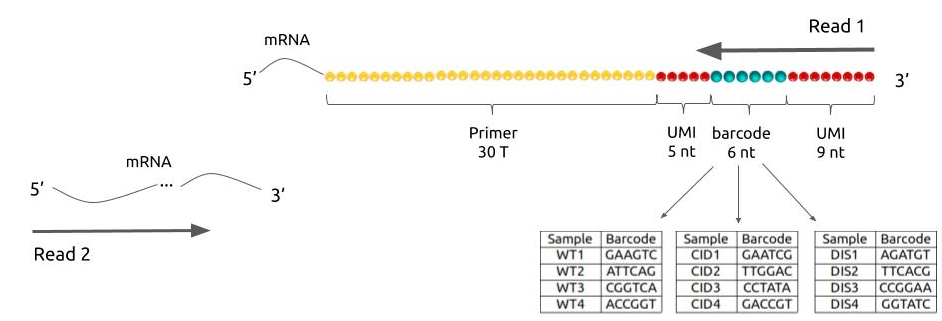

In [4]:
from IPython.display import Image
Image("Analiza_Miseq_schemat_GITHUB.png")

### Textfile containing barcodes

In [5]:
barcodes_samples = pd.read_csv('sample_04122019_MySeq/lib_122019_barcodes.txt', sep = '\t')
print(barcodes_samples)

    Name      B1
0    WT1  GAAGTC
1    WT2  ATTCAG
2    WT3  CGGTCA
3    WT4  ACCGGT
4   CID1  GAATCG
5   CID2  TTGGAC
6   CID3  CCTATA
7   CID4  GACCGT
8   DIS1  AGATGT
9   DIS2  TTCACG
10  DIS3  CCGGAA
11  DIS4  GGTATC


### Import the libraries

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import nan

%matplotlib inline

### Please look at the quality of the data unisng fastqc ofr multiqc

In [12]:
# the folowing command will run multiqc for all of the fastq files in the local dispository

!fastqc sample_R1.fastq
!fastqc sample_R2.fastq

Skipping 'sample_R1.fastq' which didn't exist, or couldn't be read
Skipping 'sample_R2.fastq' which didn't exist, or couldn't be read


### Quality control of Read 1

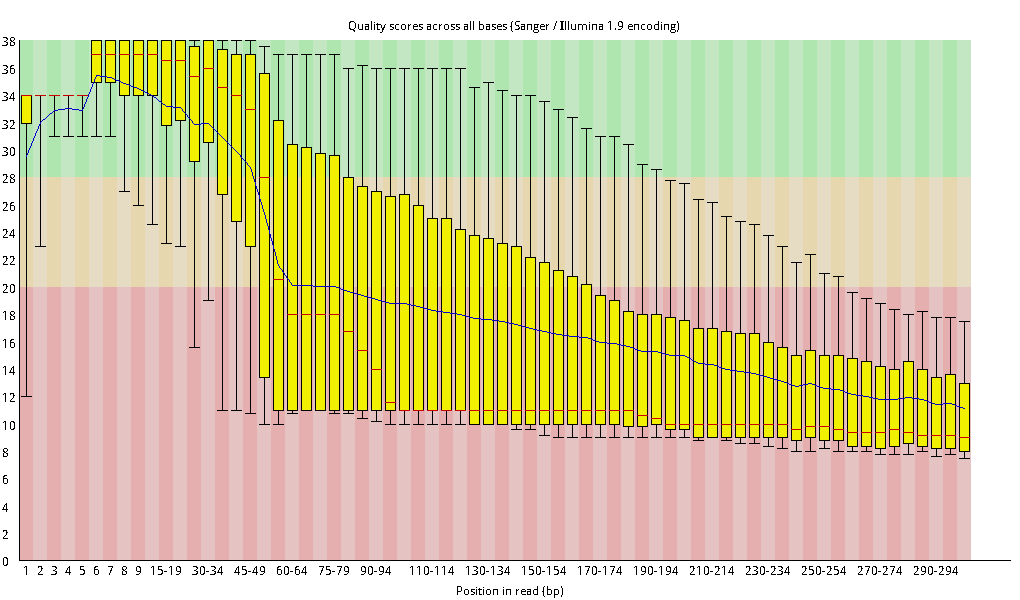

In [13]:
from IPython.display import Image
Image("figures_GITHUB/fastqc_R1.png")


### Quality control of Read 2

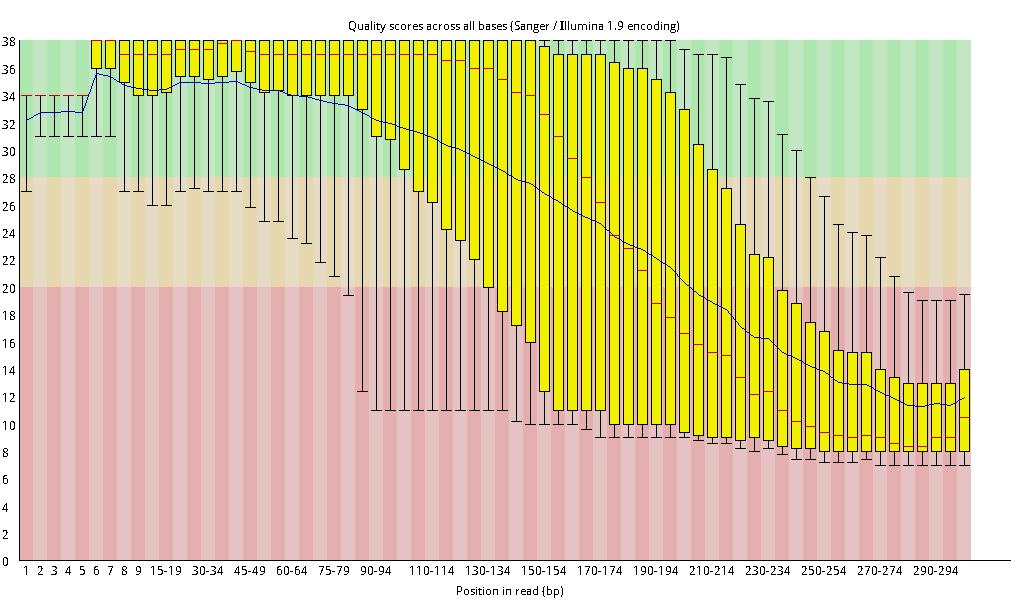

In [11]:
from IPython.display import Image
Image("figures_GITHUB/fastqc_R2.png")


### According to the quality of the reads we will trim the reads. We will trim 60 nt of Read 2, and we will rearange Read 1 to have the barcode at the beginning of the read. 


In [ ]:
#Read 1 - Move the barcode behind the UMIs:
!sed -e '2~2s/\(.\{9\}\)\(.\{6\}\)\(.\{5\}\).*/\2\1\3/' sample_04122019_MySeq/Malecki-cDNA_S17_L001_R1_001.fastq > roboczy_LL/new_R1_sed_dodemultfirst.fastq

In [ ]:
# or if I want to remove also 5xV:
#!sed -e '2~2s/\(.\{9\}\)\(.\{6\}\)\(.\{5\}\).*/\2\1/' R1.fastq > new_R1.fastq

In [2]:
# Read 2 - Trim first 60 nt (according to quality control)
!fastp -i R2.fastq -o trim_60_R2.fastq -Q -L -Y 0 -A -G -f 10 -b 60

### Wyniki po fastp: 


*fastp -i sample_04122019_MySeq/Malecki-cDNA_S17_L001_R2_001.fastq -o roboczy_LL/trim_60_R2.fastq -Q -L -Y 0 -A -G -f 10 -b 60*


**Read1 before filtering:**

        total reads: 328762
        total bases: 88649688
        Q20 bases: 56430266(63.6553%)
        Q30 bases: 47148974(53.1857%)

**Read1 after filtering:**

        total reads: 328762
        total bases: 19692898
        Q20 bases: 18648844(94.6983%)
        Q30 bases: 17165769(87.1673%)

**Filtering result:**

        reads passed filter: 328762
        reads failed due to low quality: 0
        reads failed due to too many N: 0

**Duplication rate** (may be overestimated since this is SE data): 0.654962%

        JSON report: fastp.json
        HTML report: fastp.html

*fastp -i sample_04122019_MySeq/Malecki-cDNA_S17_L001_R2_001.fastq -o roboczy_LL/trim_60_R2.fastq -Q -L -Y 0 -A -G -f 10 -b 60*

        fastp v0.20.0, time used: 1 seconds

# Approach A: 
 > # Alignment of fastq file containing all samples with different barcodes (here 12 barcodes), and usage of BRB-Seq CreateDGEMatrix to demultiplex the samples according barcodes and analyse them in the one step -- to obtain data frames with reads per genes and umis per genes.

***
## Step 1: Alignment with STAR
***

#### Create folders for Star index and for output data - Do it only once!

In [ ]:
%bash

# Create folder for STAR index, and output folder
mkdir STAR_Index/
mkdir BAM/

### Generate the STAR genome index (in 'STAR_Index' folder) => This require ~30G RAM

Prepare the reference files both in fasta and in gtf. The files for *Schizosaccharomyces pombe* can be downloaded from [Pombase](https://www.pombase.org/datasets).

    
#### Notes: 
    1.you can add the argument '--runThreadN 4' for running 4 threads in parallel (or more if your computer has enough cores)
    2. Note: if genome is not human, you need to add/tune the argument '--genomeSAindexNbases xx' with xx = log2(nbBasesInGenome)/2 - 1. For e.g. for drosophila melanogaster xx ~ 12.43, thus you should add the argument '--genomeSAindexNbases 12'

In [ ]:
(
!STAR --runMode genomeGenerate --genomeDir STAR_Index/ --genomeFastaFiles 
    reference/Schizosaccharomyces_pombe.ASM294v2.dna.toplevel.fa 
    --sjdbGTFfile reference/gSchizosaccharomyces_pombe.ASM294v2.29.gtf
)

### Align only the R2 fastq file (using STAR, no sorting/indexing is needed)

#### Notes:
    1. you can add the argument '--runThreadN 4' for running 4 threads in parallel  (or more if your computer has enough cores)
    2. (optional) Rename the output aligned BAM

In [ ]:
(
    
!STAR --runMode alignReads --genomeDir reference/STAR_Index/ 
    --outFilterMultimapNmax 1 --readFilesCommand zcat --outSAMtype BAM Unsorted 
    --outFileNamePrefix BAM/ --readFilesIn roboczy_LL/trim_60_R2.fastq.gz 
)

***
## Step 2: Analysis of the summary file after alignment with STAR
***
plik 'BAM/Log.final.out' traktuję regexem, żeby móc go analizować w Pandas

                              Started job on |	Jan 16 16:18:09
                             Started mapping on |	Jan 16 16:18:10
                                    Finished on |	Jan 16 16:18:40
       Mapping speed, Million of reads per hour |	39.45

                          Number of input reads |	328762
                      Average input read length |	59
            
                                    UNIQUE READS:
                   Uniquely mapped reads number |	195336
                        Uniquely mapped reads % |	59.42%
                          Average mapped length |	59.35
                       Number of splices: Total |	8466
            Number of splices: Annotated (sjdb) |	4355
                       Number of splices: GT/AG |	6249
                       Number of splices: GC/AG |	89
                       Number of splices: AT/AC |	22
               Number of splices: Non-canonical |	2106
                      Mismatch rate per base, % |	0.77%
                         Deletion rate per base |	0.00%
                        Deletion average length |	1.19
                        Insertion rate per base |	0.00%
                       Insertion average length |	1.04
                    
                             MULTI-MAPPING READS:
        Number of reads mapped to multiple loci |	0
             % of reads mapped to multiple loci |	0.00%
        Number of reads mapped to too many loci |	105212
             % of reads mapped to too many loci |	32.00%
             
                                  UNMAPPED READS:
                                  
      Number of reads unmapped: too many mismatches |	0
       % of reads unmapped: too many mismatches |	0.00%
            Number of reads unmapped: too short |	28171
                 % of reads unmapped: too short |	8.57%
                Number of reads unmapped: other |	43
                     % of reads unmapped: other |	0.01%
                                  CHIMERIC READS:
                       Number of chimeric reads |	0
                            % of chimeric reads |	0.00%

### Visualize the summary of alignment with seaborn

In [16]:
summary_mappowanie = pd.read_csv('BAM/Podsumowanie_mapowania.csv', sep = ',')

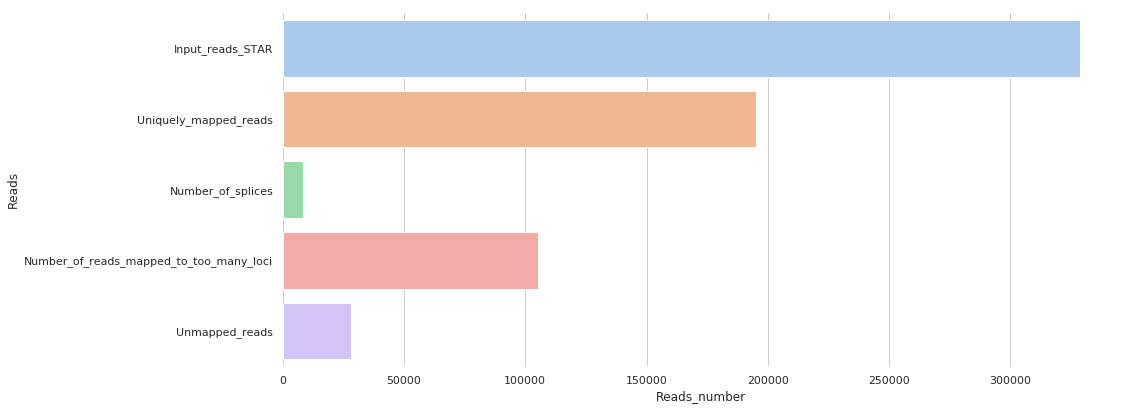

In [18]:
# Import seaborn if you didn't do that
import seaborn as sns

#Set the style of the plots 
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Draw a scatter plot
f, ax = plt.subplots(figsize=(15, 6.5))
sns.despine(f, left=True, bottom=True)
sns.barplot(data = summary_mappowanie, x='Reads_number', y='Reads')

### Visualize the percentage of alignment with matplotlib
The results for piechart are from the summary of the alignment.

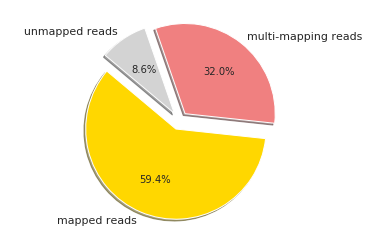

In [19]:
#import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

labels = 'mapped reads', 'multi-mapping reads', 'unmapped reads'
sizes = [195336,105212, 28214]
colors = ['gold',  'lightcoral', 'lightgray']
explode = (0.1, 0.1, 0.1)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

***

## Step 3: Demultiplex and generate output count/UMI matrix with BRBseq tools

***

### Create DGE Matrix

This tool is used when you don't need the intermediary .fastq & .bam files from all your multiplexed samples. It greatly simplifies the demultiplexing and analysis, and directly generates a workable count/UMI matrix.

**Options:**

        -f %s           [Required] Path of R1 FastQ file [can be gzipped or raw].
        -b %s           [Required] Path of R2 aligned BAM file [do not need to be sorted or indexed].
        -c %s           [Required] Path of Barcode/Samplename mapping file¹.
        -gtf %s         [Required] Path of GTF file [can be gzipped or raw].
        -s %s           Do you want to count only reads falling on same strand than gene? [no, yes, reverse] (default = yes since BRB-seq is stranded protocol)
        -n %i           Number of allowed difference with the barcode [ambiguous reads will be automatically discarded].
        -o %s           Output folder
        -t %s           Path of existing folder for storing temporary files
        -chunkSize %i   Maximum number of reads to be stored in RAM (default = 10000000)
        -p %s           Barcode pattern/order found in the reads of the R1 FastQ file. Barcode names should match the barcode file (default = 'BU' i.e. barcode followed by the UMI).
                                'B' [required] is used for specifying the barcode position.
                                'U' [optional] is used for specifying a UMI value position.
                                Character '?' [optional] can be used to ignore specific nucleotides.
        -UMI %i         If your barcode pattern contains UMI ('U'), you should specify this parameter as the length of the UMI.
        
        
#### Notes: 
    1. This example suppose that R1 has barcode followed by 14bp UMI
    2. The ‘-p’ option specifies the pattern in the R1 fastq files. If you sequenced only the 6bp barcode then you should use ‘-p B’, but if you sequenced the barcode + 10bp UMIs, then it should be ‘-p BU’ (for Barcode followed by UMI) and then you need to specify the UMI length with ‘-UMI 10’. 
    3. Note: In case you sequenced some bp you don’t want to use, you can use the ‘?’ character. For e.g. you sequenced 10bp UMI but the R1 contains extra 4bp after the UMI that are not UMI, then you should use “-p BU???? -UMI 10”
    4. 'lib_example_barcodes.txt' should be created by the user and should contain the mapping between the barcode and the sample name¹


In [ ]:
# Demultiplex and generate output count/UMI matrix
!java -jar BRBseqTools.1.3.jar CreateDGEMatrix -f BAM/BAM_demultiplexed_first/fastq_mapped/WT1.fastq -b BAM/BAM_demultiplexed_first/BAM_demultiplexed_first/bam_mapped/WT1.bam -c sample_04122019_MySeq/lib_122019_barcodes.txt -gtf reference/Schizosaccharomyces_pombe.ASM294v2.29.gtf -p BU -UMI 14 -o output
BRBSeqTools 1.3 [CreateDGEMatrix]

### Use deepTools to visualize the results: computeMatrix and plotProfile

#### STEPS:
>    1. Sort bam file (output of alignment with STAR): 
    
    samtools sort input.bam > input_sorted.bam
    
>    2. Index sorted bam: 

    samtools index input_sorted.bam*
    
>    3. Prepare bigwig file: 

    bamCoverage -b input_sorted.bam -o output_sorted.bw
    
>    4. Use function cumputeMatrix (here you need .bw file and .bed file with references):
    
    computeMatrix scale-regions -S input.bw -R referencje.bed --beforeRegionStartLength 3000 --regionBodyLength5000 --afterRegionStartLength 3000 --skipZeros -o matrix.mat.gz
    
>    5. Make the plot with plotProfile:
    
    plotProfile -m matrix.mat.gz -out plots/output_plot.png --perGroup
    
>    6. Congrats! You just visualized where the reads are aligned - in comparison with transcription start site (tss) and transcription end side (tes). If your plot is similar to mine, it means that most of reads from Read 2 aligned near 3' end of mRNA. 

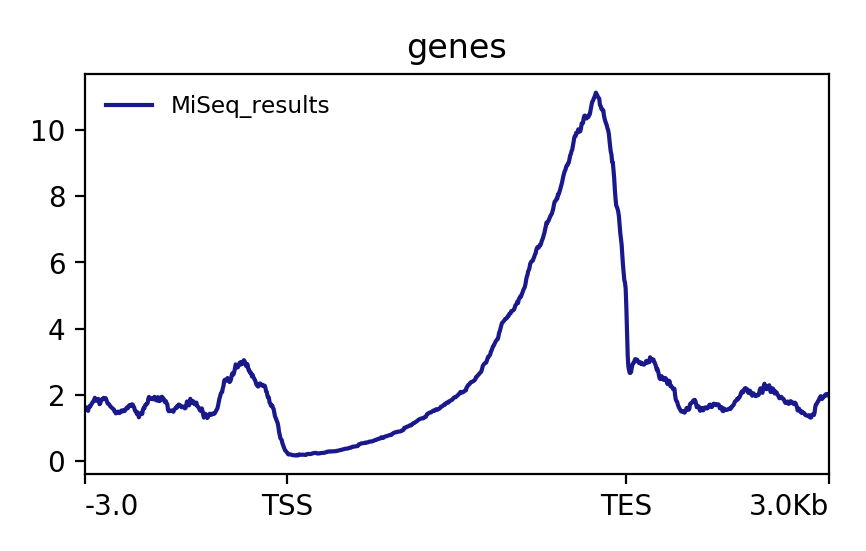

In [150]:
Image('figures_GITHUB/computematrix_onlygenes.png')

*** 
## Step 4: Analyse the results - countmatrix (reads per gene) and umimatrix (UMIs per gene)
***

### Analyse the output data

In [21]:
#Read the DataFrame with results after BRBSeq analysis
counttable_brbrseq = pd.read_csv('output/output.dge.reads.detailed.txt', sep = '\t')
umimatrix_brbrseq = pd.read_csv('output/output.dge.umis.detailed.txt', sep = '\t')

# Drop the columns with the summary (last columns)
brbrseq_summary = counttable_brbrseq[counttable_brbrseq.Gene_id.str.contains("__")]
umimatrix_summary = umimatrix_brbrseq[umimatrix_brbrseq.Gene_id.str.contains("__")]

#Remove last columns containinf
counttable_brbrseq_bezsummary = counttable_brbrseq[~counttable_brbrseq.Gene_id.str.contains("__")]
umimatrix_bezsummary = umimatrix_brbrseq[~umimatrix_brbrseq.Gene_id.str.contains("__")]

umimatrix_bezsummary.head()

,Gene_id,Gene_name,DIS3,WT4,CID1,DIS4,WT3,DIS1,DIS2,Unknown_Barcode,WT1,CID3,WT2,CID2,CID4
0,SPAC1002.01,SPAC1002.01,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SPAC1002.02,pom34,1,0,0,0,0,0,0,0,0,0,0,0,0
2,SPAC1002.03c,gls2,0,1,2,2,2,1,0,0,1,3,3,1,1
3,SPAC1002.04c,taf11,0,0,0,1,0,0,0,0,0,0,0,1,0
4,SPAC1002.05c,jmj2,0,0,0,0,0,0,0,0,0,0,0,0,0


### Number of reads per sample

In [30]:
columns = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4', 
           'Unknown_Barcode']


samples = pd.Series(columns)
reads = []

for i in columns:
    sum_reads_i = counttable_brbrseq_bezsummary[i].sum()
    reads.append(sum_reads_i)
    
reads = pd.Series(reads)

reads_per_sample = pd.DataFrame({
    'samples': samples,
    'number_reads': reads
})

print(reads_per_sample)


            samples  number_reads
0               WT1          9626
1               WT2         18119
2               WT3         11271
3               WT4         12358
4              CID1         14737
5              CID2         11658
6              CID3         31178
7              CID4          8338
8              DIS1         17304
9              DIS2          6274
10             DIS3         10970
11             DIS4         11024
12  Unknown_Barcode         17089


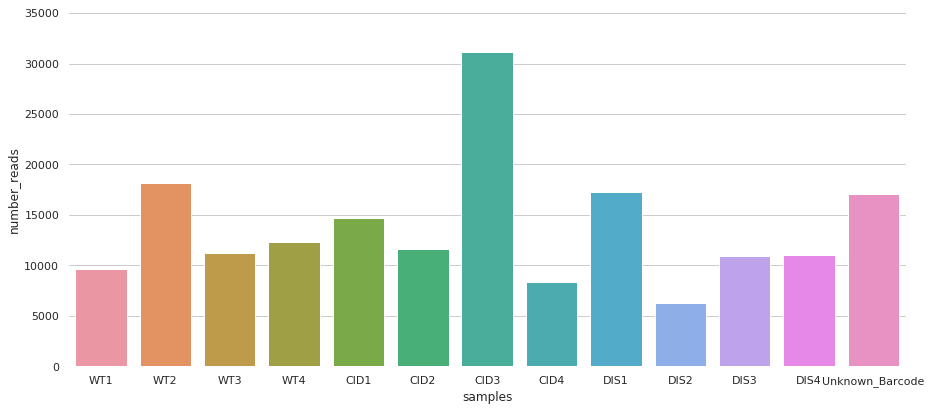

In [31]:
# Wszystkie wyniki (razem z summary)

sns.set(style="whitegrid")
# Draw a scatter plot
f, ax = plt.subplots(figsize=(15, 6.5))
sns.despine(f, left=True, bottom=True)
plt.ylim([0, 35000])
sns.barplot(data = reads_per_sample, y='number_reads', x='samples')

### Number of UMIs per sample

In [32]:
# to samo, ale dla umimatrix
columns = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4', 
           'Unknown_Barcode']

samples = pd.Series(columns)
reads = []

for i in columns:
    sum_reads_i = umimatrix_bezsummary[i].sum()
    reads.append(sum_reads_i)
    
reads = pd.Series(reads)

reads_per_sample_umis = pd.DataFrame({
    'samples': samples,
    'number_umis': reads
})

print(reads_per_sample_umis)

            samples  number_umis
0               WT1         9407
1               WT2        17785
2               WT3        11057
3               WT4        12118
4              CID1        14477
5              CID2        11423
6              CID3        30573
7              CID4         8207
8              DIS1        16909
9              DIS2         6170
10             DIS3        10742
11             DIS4        10766
12  Unknown_Barcode        16354


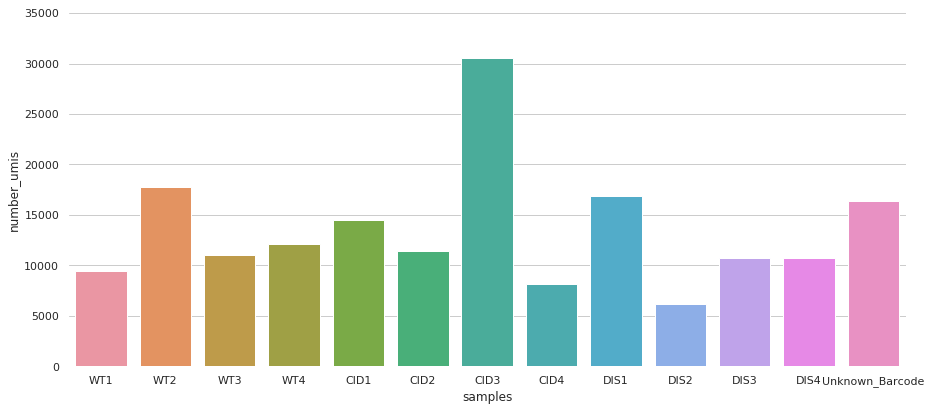

In [33]:
# Number of umis

sns.set(style="whitegrid")
# Draw a scatter plot
f, ax = plt.subplots(figsize=(15, 6.5))
sns.despine(f, left=True, bottom=True)
plt.ylim([0, 35000])
#plt.xlim([1,10**3])
sns.barplot(data = reads_per_sample_umis, y='number_umis', x='samples')

### Count the duplication level -- hom many reads in the sample for each gene vs. how many reads

In [25]:
reads_per_sample_withumis = reads_per_sample
reads_per_sample_withumis['number_umis'] = reads_per_sample_umis['number_umis']
reads_per_sample_withumis['duplicated_reads'] = reads_per_sample_withumis['number_reads']-reads_per_sample_withumis['number_umis']
reads_per_sample_withumis['Procent_of_duplication'] = 100*reads_per_sample_withumis['duplicated_reads']/reads_per_sample_withumis['number_reads']
reads_per_sample_withumis

,samples,number_reads,number_umis,duplicated_reads,Procent_of_duplication
0,WT1,9626,9407,219,2.275088
1,WT2,18119,17785,334,1.843369
2,WT3,11271,11057,214,1.898678
3,WT4,12358,12118,240,1.942062
4,CID1,14737,14477,260,1.764267
5,CID2,11658,11423,235,2.015783
6,CID3,31178,30573,605,1.940471
7,CID4,8338,8207,131,1.571120
8,DIS1,17304,16909,395,2.282709
9,DIS2,6274,6170,104,1.657635


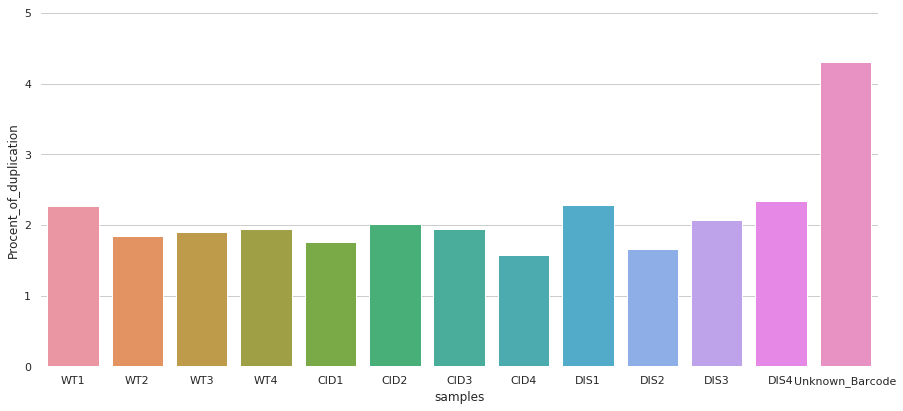

In [36]:
# Number of dulicated reads

sns.set(style="whitegrid")
# Draw a scatter plot
f, ax = plt.subplots(figsize=(15, 6.5))
sns.despine(f, left=True, bottom=True)
plt.ylim([0, 5])
sns.barplot(data = reads_per_sample_withumis, y='Procent_of_duplication', x='samples')

### Number of reads per gene -- Correlation between samples

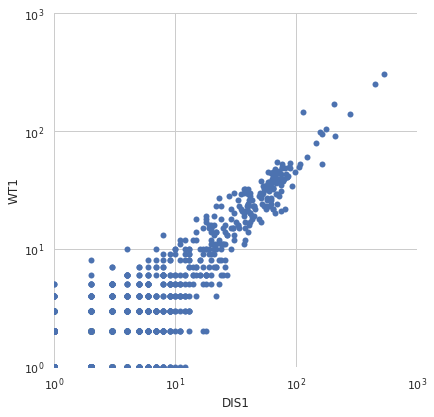

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
# Draw a scatter plot
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim([1,10**3])
plt.xlim([1,10**3])
sns.scatterplot(data = counttable_brbrseq, y='WT1', 
                x='DIS1',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                ax=ax)

### Filtration of results

In [40]:
counttable_brbrseq_bezsummary

,Gene_id,Gene_name,DIS3,WT4,CID1,DIS4,WT3,DIS1,DIS2,Unknown_Barcode,WT1,CID3,WT2,CID2,CID4
0,SPAC1002.01,SPAC1002.01,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SPAC1002.02,pom34,1,0,0,0,0,0,0,0,0,0,0,0,0
2,SPAC1002.03c,gls2,0,1,2,2,2,1,0,0,1,3,3,1,1
3,SPAC1002.04c,taf11,0,0,0,1,0,0,0,0,0,0,0,1,0
4,SPAC1002.05c,jmj2,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,SPSNRNA.03,snu3,0,0,0,0,0,0,0,0,0,0,0,0,0
7011,SPSNRNA.04,snu4,0,0,0,0,0,0,0,0,0,0,0,0,0
7012,SPSNRNA.05,snu5,0,0,0,0,0,0,0,0,0,0,0,0,0
7013,SPSNRNA.06,snu6,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# Remove the rows where the values of reads for all of the columns is zero. 
# Previously, I prepared the file with NaN values where all of values were zeroes. (REGEX)

df = pd.read_csv('output_filtracja2.txt', sep = ',')

df = df.dropna()
df = df.set_index("Gene_name")
df.head()

,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
Gene_name,,,,,,,,,,,,
pom34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
gls2,1.0,3.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0
taf11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
ats1,0.0,3.0,1.0,4.0,0.0,3.0,5.0,1.0,2.0,0.0,2.0,1.0
mtf1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


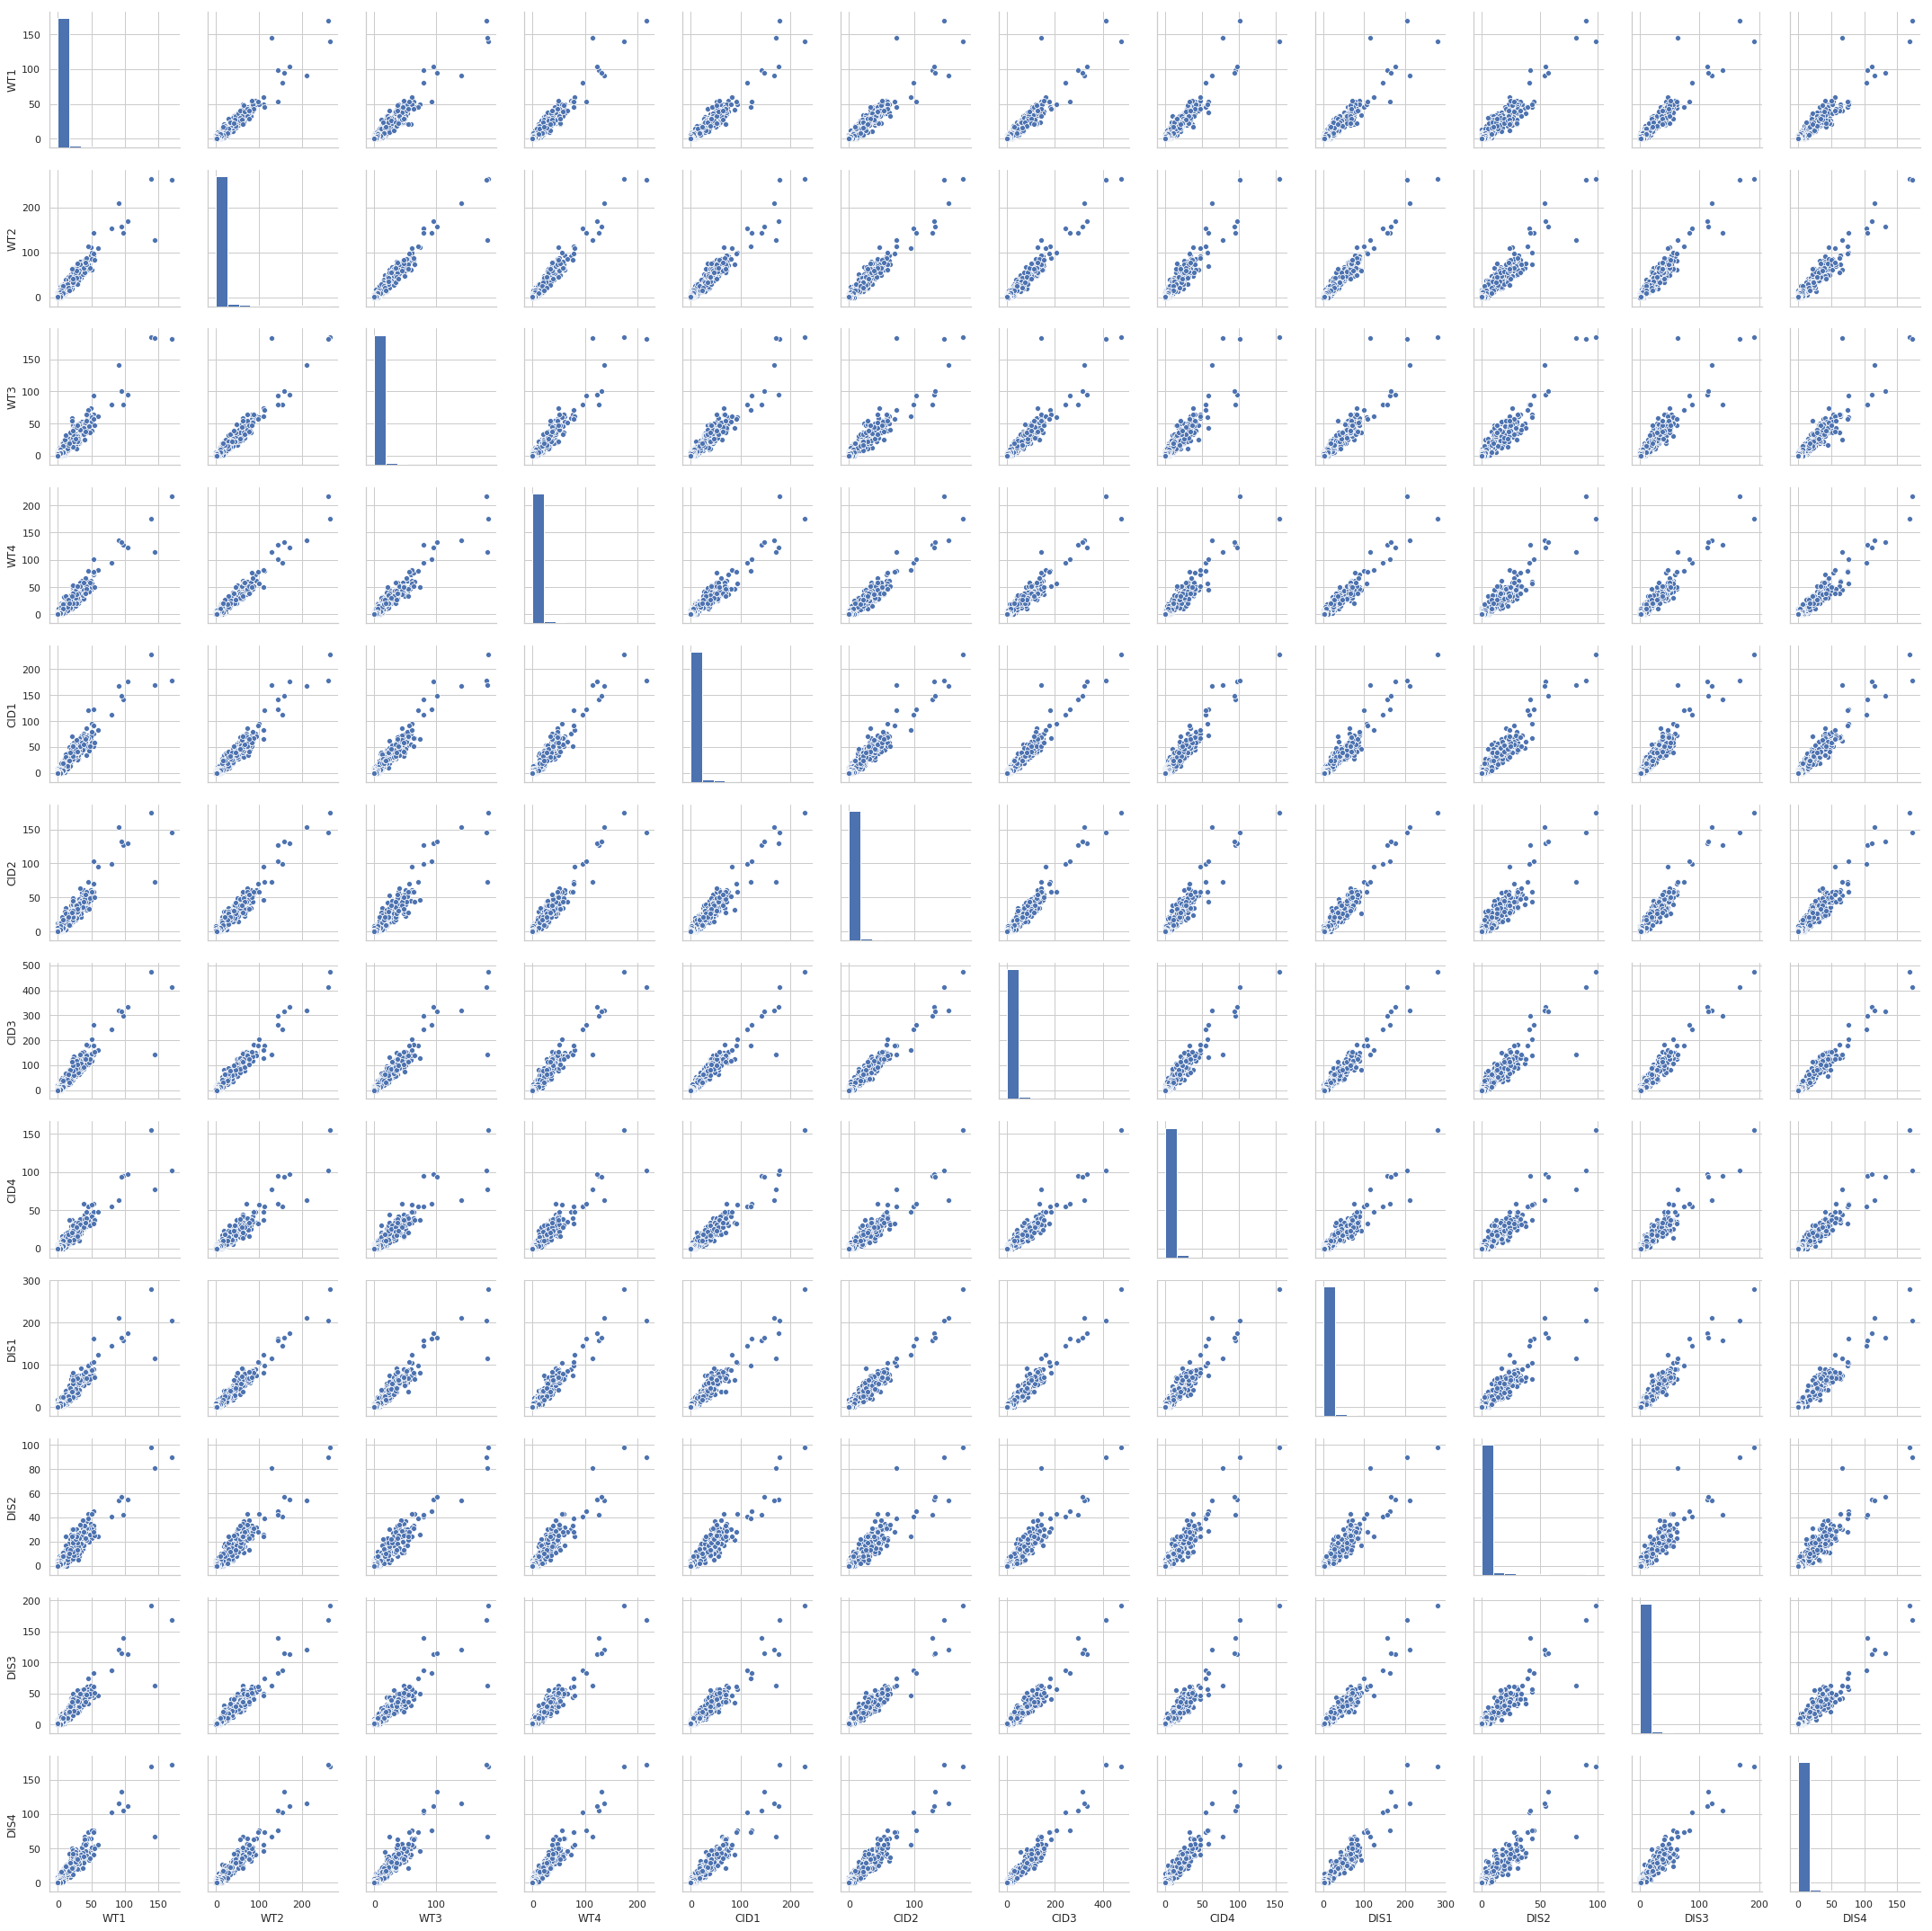

In [42]:
sns.pairplot(df)

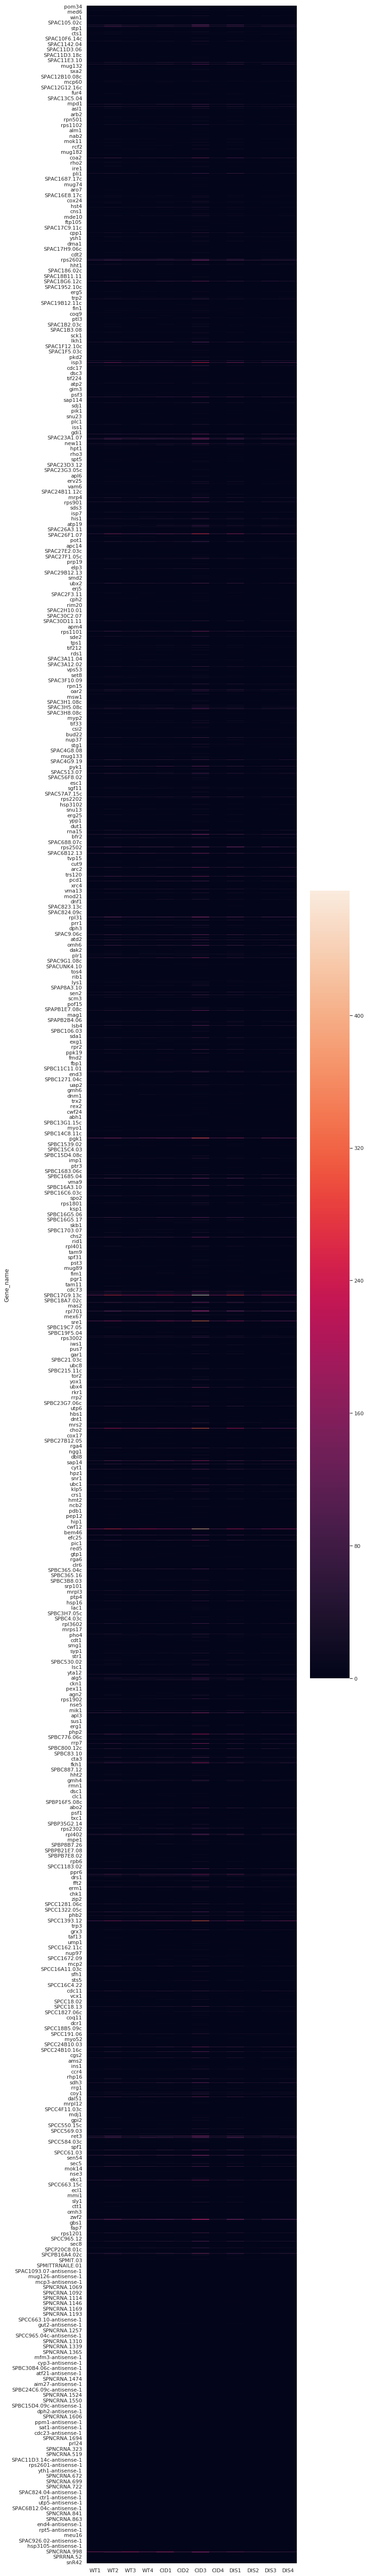

In [43]:
plt.subplots(figsize=(10,100))
sns.heatmap(df)

### Filtration -- only genes covered by more than 5 reads

In [44]:
new_df = df[df.loc[:]>5].dropna()
new_df.head()

,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
Gene_name,,,,,,,,,,,,
rps1502,26.0,50.0,28.0,31.0,38.0,35.0,104.0,27.0,62.0,20.0,22.0,24.0
rpp203,16.0,34.0,21.0,18.0,29.0,18.0,56.0,16.0,33.0,7.0,19.0,17.0
pma1,49.0,111.0,74.0,50.0,66.0,47.0,127.0,38.0,81.0,26.0,50.0,46.0
vip1,8.0,20.0,6.0,11.0,8.0,7.0,16.0,8.0,8.0,8.0,16.0,10.0
pss1,18.0,24.0,17.0,14.0,20.0,9.0,40.0,7.0,24.0,9.0,13.0,11.0


In [ ]:
### Draw the heatmap with the mask and correct aspect ratio

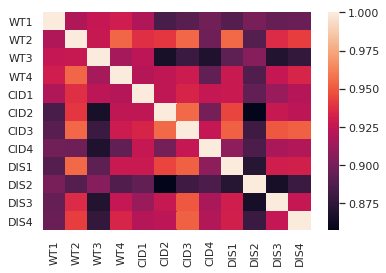

In [48]:
corr = new_df.corr()
sns.heatmap(corr)

In [49]:
#Normalization - the results for each sample are divided by the mean value from the column
df_pca = new_df

columns = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4']

for i in columns:
    mean_i = df_pca[i].mean()
    df_pca[i] = df_pca[i]/mean_i
df_pca.head()

,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
Gene_name,,,,,,,,,,,,
rps1502,0.885845,0.942663,0.813174,0.828375,0.839158,0.985915,1.118032,1.054348,1.163362,1.024828,0.652699,0.711165
rpp203,0.545135,0.641011,0.609880,0.480992,0.640410,0.507042,0.602017,0.624799,0.619209,0.358690,0.563695,0.503742
pma1,1.669477,2.092711,2.149102,1.336088,1.457484,1.323944,1.365289,1.483897,1.519876,1.332277,1.483407,1.363067
vip1,0.272568,0.377065,0.174251,0.293939,0.176665,0.197183,0.172005,0.312399,0.150111,0.409931,0.474690,0.296319
pss1,0.613277,0.452478,0.493713,0.374105,0.441662,0.253521,0.430012,0.273349,0.450334,0.461173,0.385686,0.325951


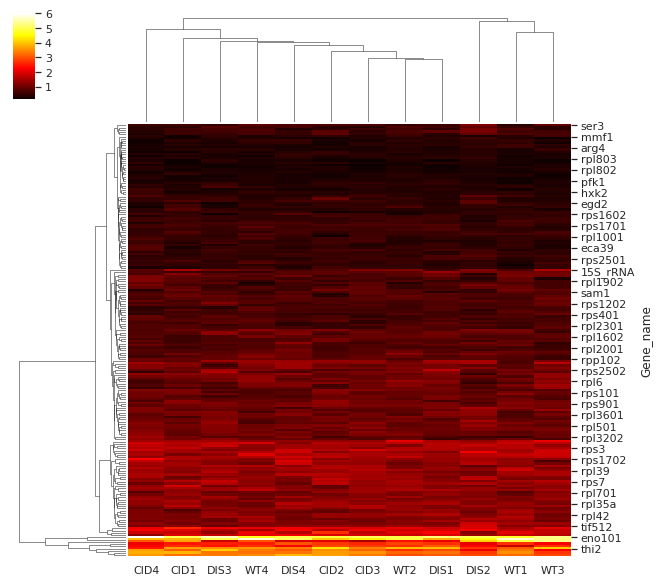

In [50]:
sns.clustermap(df_pca, cmap ='hot')

In [51]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=5)
pca.fit(df_pca)
pca.components_ 

array([[ 0.30315163,  0.28327746,  0.30575539,  0.29510924,  0.28849381,
         0.2904594 ,  0.27940614,  0.29022608,  0.27689626,  0.26417249,
         0.29476646,  0.28989123],
       [ 0.39995046, -0.04520911,  0.55489295,  0.04080059,  0.06530527,
        -0.33131526, -0.30017007, -0.0933255 , -0.21590446,  0.38341201,
        -0.27707272, -0.2125789 ],
       [-0.00592073,  0.32887283,  0.27570727,  0.33025292, -0.09214444,
         0.17505056, -0.01953165, -0.69529909,  0.16623717, -0.38595602,
        -0.0463177 , -0.07091081],
       [ 0.62868601, -0.08422871, -0.26957669,  0.32244679, -0.22116782,
        -0.15346553, -0.14078731,  0.11324494, -0.27372996, -0.38043762,
         0.29955496,  0.08068149],
       [-0.09786975,  0.05280054, -0.24368859,  0.23964747, -0.51506398,
        -0.09841783,  0.0740469 , -0.3166979 , -0.06178284,  0.63110939,
         0.14170351,  0.26050919]])

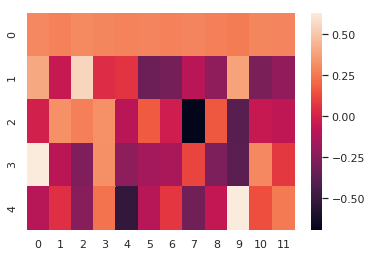

In [52]:
sns.heatmap(pca.components_)

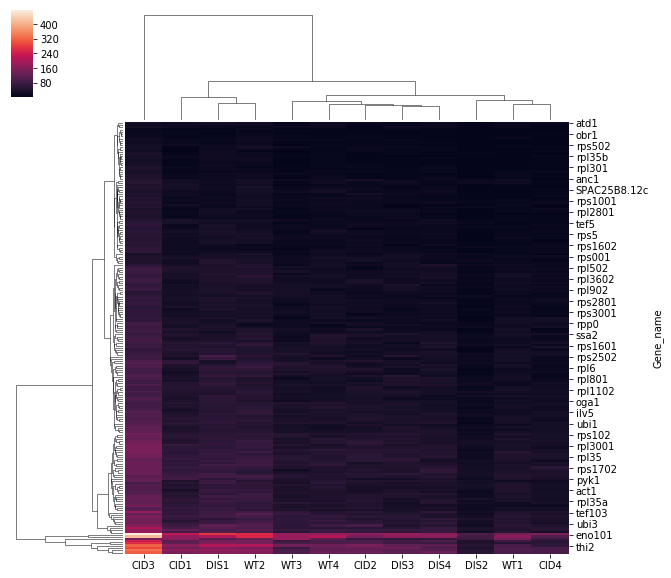

In [3]:
df2 = pd.read_csv('output_filtracja.txt', sep = '\t')

df2 = df2.dropna()
df2 = df2.set_index("Gene_name")
new_df2 = df2.drop(columns=['Gene_id', 'Unknown_Barcode'])
new_df2 = new_df2[new_df2.loc[:]>5].dropna()
sns.clustermap(new_df2)


In [78]:
df = pd.read_csv('output_filtracja2.txt', sep = ',')

df = df.dropna()
df = df.set_index("Gene_name")

df = df[df.loc[:]>5].dropna()
df.head()

,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
Gene_name,,,,,,,,,,,,
rps1502,26.0,50.0,28.0,31.0,38.0,35.0,104.0,27.0,62.0,20.0,22.0,24.0
rpp203,16.0,34.0,21.0,18.0,29.0,18.0,56.0,16.0,33.0,7.0,19.0,17.0
pma1,49.0,111.0,74.0,50.0,66.0,47.0,127.0,38.0,81.0,26.0,50.0,46.0
vip1,8.0,20.0,6.0,11.0,8.0,7.0,16.0,8.0,8.0,8.0,16.0,10.0
pss1,18.0,24.0,17.0,14.0,20.0,9.0,40.0,7.0,24.0,9.0,13.0,11.0


In [ ]:
########################### Tu w tej komorce coś do poprawki

columns = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4']

samples = pd.Series(columns)
rows = list(df.index)
for i in columns:
    tablename  = "table_{}".format(i)
    print(tablename)
    tablename[i] = pd.DataFrame({
    'genes': rows,
    'reads': df[i]})
 #   tablename['sample'] = i
  #  print(tablename)
    
    
    
    #####################

In [137]:
################# tutaaj for do dołożenia
tableDIS4['sample'] = 'DIS4'

In [138]:
frames = [tableWT1, tableWT2, tableWT3, tableWT4, tableCID1, tableCID2, tableCID3, tableCID4,
         tableDIS1, tableDIS2, tableDIS3, tableDIS4]

concatenated_tables = pd.concat(frames)
concatenated_tables.to_csv('concatenated_tables.csv')

In [139]:
concatenated_tables.head()

,genes,reads,sample
Gene_name,,,
rps1502,rps1502,26.0,WT1
rpp203,rpp203,16.0,WT1
pma1,pma1,49.0,WT1
vip1,vip1,8.0,WT1
pss1,pss1,18.0,WT1


### BONUS: Fancy plots to compare the samples

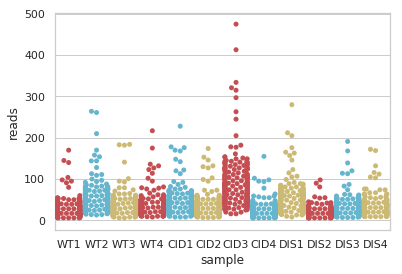

In [142]:
sns.swarmplot(x=concatenated_tables["sample"], y=concatenated_tables['reads'],
              palette=["r", "c", "y"], data=concatenated_tables)


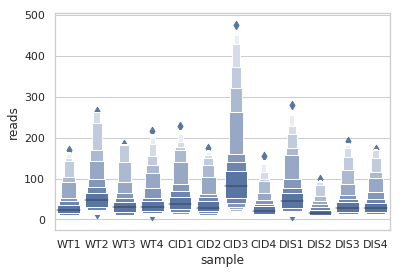

In [143]:
sns.boxenplot(x="sample", y="reads", color="b",
              scale="linear", data=concatenated_tables)

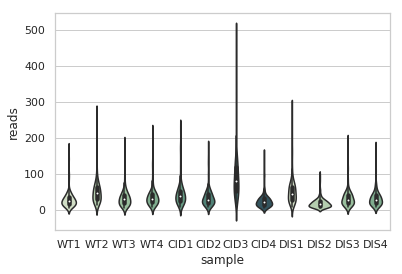

In [144]:
n, p = 40, 8
pal = sns.cubehelix_palette(p, rot=-.5, dark=.3)
sns.violinplot(x="sample", y="reads",
              color="b", data=concatenated_tables, palette=pal)

### BONUS: Description of output file SJ.out.tab - output of STAR

4.4 Splice junctions.
SJ.out.tab contains high confidence collapsed splice junctions in tab-delimited format. The columns
have the following meaning:

        column 1: chromosome
        column 2: first base of the intron (1-based)
        column 3: last base of the intron (1-based)
        column 4: strand (0: undefined, 1: +, 2: -)
        column 5: intron motif: 0: non-canonical; 1: GT/AG, 2: CT/AC, 3: GC/AG, 4: CT/GC, 5:
        AT/AC, 6: GT/AT
        column 6: 0: unannotated, 1: annotated (only if splice junctions database is used)
        column 7: number of uniquely mapping reads crossing the junction
        column 8: number of multi-mapping reads crossing the junction
        column 9: maximum spliced alignment overhang
        
The filtering for this output file is controlled by the --outSJfilter* parameters, as described in
Section 8.14. Output Filtering: Splice Junctions.


In [145]:
# Our output file SJ.out.tab
sj_column_names = ['chrom', 'intronfirstbase', 'intronlastbase', 'strand', 'intronmotif',
                  'annotated', 'nruniquelymapping', 'nrmultimapping', 'maxsplicesalignmentoverhang'] 
splice_junction = pd.read_csv('BAM/SJ.out.tab', sep = '\t', names=sj_column_names)
splice_junction.head()

,chrom,intronfirstbase,intronlastbase,strand,intronmotif,annotated,nruniquelymapping,nrmultimapping,maxsplicesalignmentoverhang
0,I,98838,136563,2,2,0,1,0,12
1,I,101747,101815,2,2,0,1,0,17
2,I,101870,101871,0,0,1,9,0,4
3,I,180529,180585,1,1,1,5,0,13
4,I,180722,180889,1,1,1,6,0,24


## STEP 5: Analysis of reads without barcodes & primers

> During quality control step of the files before alignment we found something interesting. As it was described at the beginning of the notebook, the raw fastq file containing Read 1 starts from 9-nucleotide UMI, 6-nucleotide barcode, 5-nucleotide UMI, and primer -- 30 T at the positions 21-50 in Read 1.
In the following figure we can see that in the position of primer only approx. 74% of reads has 30 Ts. We decided to analyse what about the rest od reads. 

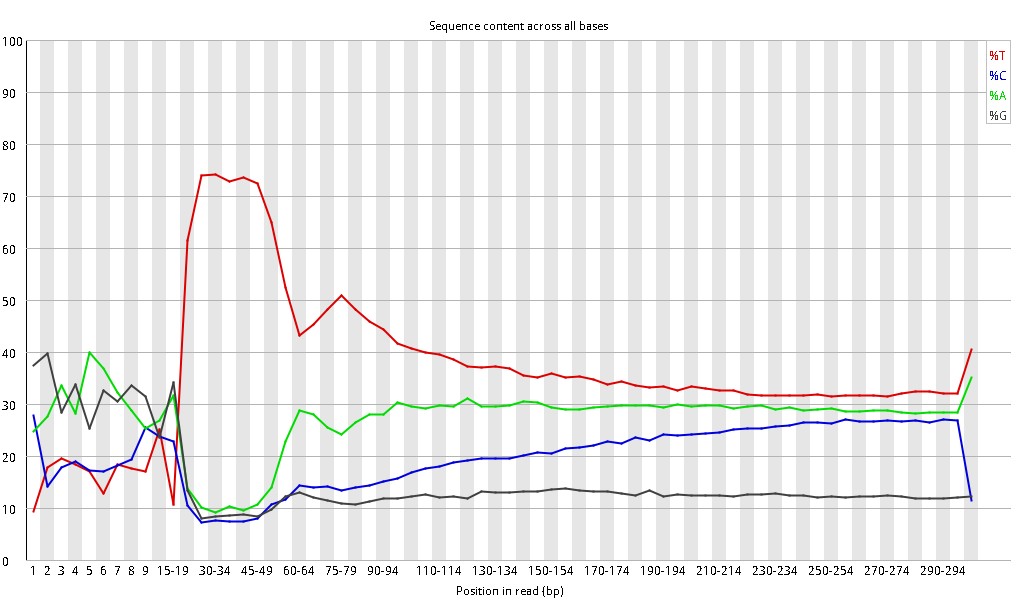

In [148]:
Image('figures_GITHUB/R1_perbasesequence content.png')

> ### Steps of this step:
    1. Remove first 20 nocleotides from Read 1 (all nucleotides before primer).
    2. Move the primer (here at least 25 T) to the header of Read 1. If we will not find at least 25 T wrere the primer should be, we will move the 25 nucleotides to the header following by the letters "mm_" (MisMatch).  
    3. Extract the new headers from Read 1.
    4. Replace the header in Read 2 with new headers from Read 1.
    5. Make an alignment and check which reads are aligned - with or without primers.    

#### Remove first 20 nucleotides of sequence from Read1 (UMI+Barcode+UMI)

In [ ]:
!cutadapt -u 20 -o roboczy_LL/cutadapted20_R1.fastq sample_04122019_MySeq/Malecki-cDNA_S17_L001_R1_001.fastq 

#### Move the primer (here at least 25 T) to the header of Read 1. If we will not find at least 25 T wrere the primer should be, we will move the 25 nucleotides to the header following by the letters "mm_" (MisMatch).  

In [ ]:
# import libraries
from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re

outfile = open("roboczy_LL/cutadapted20_R1_analiza_min25T.fastq", "w")
infile = SeqIO.parse("roboczy_LL/cutadapted20_R1.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    pattern = re.compile("^TTTTTTTTTTTTTTTTTTTTTTTTTT+")
    ogon = re.search(pattern, str(sequence))
    if ogon == None:
        ogon = "mm_" + str(sequence[0:26])
    else:
        ogon = ogon.group(0)
        ogon_length = len(ogon)
        sequence = str(sequence[ogon_length:-1])
        seq_length = len(sequence)      
        quality = str(quality[ogon_length:-1]) 
    header=str(read.id) + "_" + ogon 
    read = fastq
    new_read = '@'+header+'\n'+sequence+'\n'+strand+'\n'+ quality+'\n'      
    outfile.write(new_read) 
outfile.close()

#### Extract the new headers from Read 1

In [ ]:
from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("roboczy_LL/lista_headerow_z_R1.txt", "w")

infile = SeqIO.parse("roboczy_LL/cutadapted20_R1_analiza_min25T.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]



    new_read = header +'\n'
        
    outfile.write(new_read)
   
outfile.close()

#### Replace the header in Read 2 with new headers from Read 1

In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
i =-1

infile_R1 = "roboczy_LL/lista_headerow_z_R1.txt"
with open(infile_R1) as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

outfile = open("roboczy_LL/trim_R2_new_header.fastq", "w")


infile_R2 = SeqIO.parse("roboczy_LL/trim_60_R2_copy.fastq", "fastq")
#for read in range(0, len(content)):
for read in infile_R2:
    i = i+1
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]

    header  =content[i]

    new_read =  header+'\n' +sequence+'\n'+strand+'\n'+ quality+'\n'

    outfile.write(new_read)
   
outfile.close()

#### Short look at the results number of reads with & without primer before and after alignment

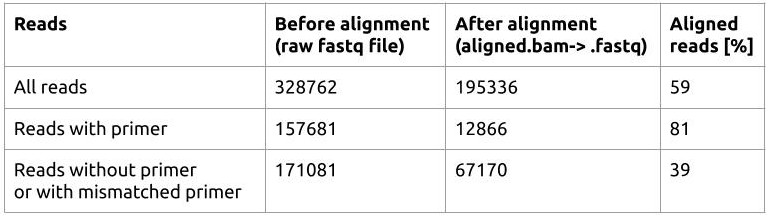

In [152]:
#The following command allows you to count the number of lines in file:
#!wc -l plik

#To count number of reads - just divide the number by 4 (each read in fastq format has 4 lines)

Image('figures_GITHUB/reads_without_primers.jpg')

## STEP 6: Remove the duplications with DEDUP UMI-Tools

>Deduplicate reads based on the mapping co-ordinate and the UMI attached to the read.

#### Procedure:
    Move UMI (9nt UMI + 6 nt barcode) from R1 to header of R2 (the script below, Biopython)
    Mapping of R2  (STAR), samtools sort .bam, samtools index .bam
    Dedup, input: bam file, output: bam file + raport file


#### Move UMI (9nt UMI + 6 nt barcode) from R1 to header of R2

In [33]:
from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("roboczy_LL/R1_15umi_w_headerze.fastq", "w")

infile = SeqIO.parse("sample_04122019_MySeq/Malecki-cDNA_S17_L001_R1_001.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    umis = str(sequence[0:15])   
    header=str(read.id) + "_" + umis 
    new_read = '@'+header+'\n'+sequence+'\n'+strand+'\n'+ quality+'\n'      
    outfile.write(new_read)
   
outfile.close()

In [35]:
# Ekstrakcja headerów z R1 z poprzedniego kroku (zawierają primer lub info, że nie ma primera)

from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("roboczy_LL/lista_headerow_z_15UMI_R1.txt", "w")

infile = SeqIO.parse("roboczy_LL/R1_15umi_w_headerze.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    new_read = header +'\n'       
    outfile.write(new_read)
   
outfile.close()

In [36]:
## TO DZIAŁA I PRZERZUCA primer z R1 do R2

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
i =-1

infile_R1 = "roboczy_LL/lista_headerow_z_15UMI_R1.txt"
with open(infile_R1) as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

outfile = open("roboczy_LL/trim_R2_new_header_15UMI.fastq", "w")


infile_R2 = SeqIO.parse("roboczy_LL/trim_60_R2_copy.fastq", "fastq")
#for read in range(0, len(content)):
for read in infile_R2:
    i = i+1
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]

    header  =content[i]

    new_read =  header+'\n' +sequence+'\n'+strand+'\n'+ quality+'\n'

    outfile.write(new_read)
   
outfile.close()

#### Alignment with STAR, samtools sort .bam, samtools index .bam

In [ ]:
############
DO DOPISANIA

#### Run umi-tools dedup

In [ ]:
!umi_tools dedup --stdin=BAM/BAM_dedup/sorted_dedup.bam --log=BAM/BAM_dedup/dedup_logfile.txt > BAM/BAM_dedup/dedup_20200206.bam

 #### Dedup -RESULTS:
    Input Reads: 195336
    Number of reads out: 188910
    Total number of positions deduplicated: 90175
    Mean number of unique UMIs per position: 2.11
    Max. number of unique UMIs per position: 318


***

# Approach B:
 > # Demultiplexing the samples according the barcodes at first, alignment of separated samples, and analysis them

## STEP 1: Demultiplexing of raw fastq files (both Read 1 and Read 2) according to barcode

#### There are following tools to do demultiplexing:

    A. BRBseq Demultiplex
    B. Sambre

### A. BRBseq Demultiplex
This tool is used when you need to generate all the fastq files corresponding to all your multiplexed samples. You end up with one fastq file per sample.

Note: If you use the "AnnotateBAM" tool, you can also demultiplex the annotated BAM file using GATK SplitReads

#### Options:

    -r1 %s          [Required] Path of R1 FastQ files (containing barcode and optionally UMIs) [can be gzipped or raw].
    -r2 %s          [Required] Path of R2 FastQ files (containing read sequence) [can be gzipped or raw].
    -c %s           [Required] Path of Barcode/Samplename mapping file¹.
    -n %i           Number of allowed difference with the barcode [Default = 1]. Ambiguous barcodes (same distance from two or more existing barcodes) will be automatically discarded.
    -o %s           Output folder
    -p %s           Barcode pattern/order found in the reads of the R1 FastQ file. Barcode names should match the barcode file (default = 'BU' i.e. barcode followed by the UMI).
                        'B' [required] is used for specifying the barcode position.
                        'U' [optional] is used for specifying a UMI value position.
                        Character '?' [optional] can be used to ignore specific nucleotides.
    -UMI %i         If your barcode pattern contains UMI ('U'), you should specify this parameter as the length of the UMI.

In [2]:
# example:
!java -jar BRBseqTools.jar Demultiplex -r1 sample_04122019_MySeq/Malecki-cDNA_S17_L001_R1_001.fastq -r2 sample_04122019_MySeq/Malecki-cDNA_S17_L001_R2_001.fastq -c sample_04122019_MySeq/lib_122019_barcodes.txt-p BU -UMI 14

Error: Unable to access jarfile BRBseqTools.jar


## B. Demultiplexing with Sabre

In [5]:
# przerzucam barcody do headera.

from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("roboczy_LL/R1_6barcode_w_headerze.fastq", "w")

infile = SeqIO.parse("sample_04122019_MySeq/Malecki-cDNA_S17_L001_R1_001.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    barcode = str(sequence[9:15])   
    header=str(read.id) + "_" + barcode 
    new_read = '@'+header+'\n'+sequence+'\n'+strand+'\n'+ quality+'\n'      
    outfile.write(new_read)
   
outfile.close()

In [13]:
# Ekstrakcja barcodów (na razie cały header z barcodem) z R1 z poprzedniego kroku

from Bio import SeqIO
from Bio.Seq import MutableSeq
import pandas as pd
import re
outfile = open("roboczy_LL/lista_barcodów_6nt_R1.txt", "w")

infile = SeqIO.parse("roboczy_LL/R1_6barcode_w_headerze.fastq", "fastq")
for read in infile:
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]
    header = header.split('_')[1]
    new_read = header +'\n'       
    outfile.write(new_read)
   
outfile.close()

In [26]:
## TO DZIAŁA I PRZERZUCA barcode z R1 do R2

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
i =-1

infile_R1 = "roboczy_LL/lista_barcodów_6nt_R1.txt"
with open(infile_R1) as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

outfile = open("roboczy_LL/trim_R2_with_barcodefromR1.fastq", "w")


infile_R2 = SeqIO.parse("sample_04122019_MySeq/trim_60_R2.fastq", "fastq")
#for read in range(0, len(content)):
for read in infile_R2:
    i = i+1
    fastq = read.format("fastq")
    header = fastq.partition('\n')[0]
    sequence = fastq.splitlines()[1]
    strand = fastq.splitlines()[2]
    quality = fastq.splitlines()[3]

    sequence  =str(content[i]+sequence)
    quality = str(content[i] + quality)

    new_read =  header+'\n' +sequence+'\n'+strand+'\n'+ quality+'\n'

    outfile.write(new_read)
   
outfile.close()

### Run demultiplexing with sabre

In [20]:
!Demutiplexing/sabre se -m 2 -f roboczy_LL/trim_R2_with_barcodefromR1.fastq -b Demutiplexing/barcodes_first.txt -u unknown_barcode.fastq

#### Results of demultiplexing with sabre:

    Total FastQ records: 328762
    FastQ records for barcode GGTATC: 18456
    FastQ records for barcode CCGGAA: 21678
    FastQ records for barcode TTCACG: 14916
    FastQ records for barcode AGATGT: 31546
    FastQ records for barcode GACCGT: 12210
    FastQ records for barcode CCTATA: 43706
    FastQ records for barcode TTGGAC: 17976
    FastQ records for barcode GAATCG: 23555
    FastQ records for barcode ACCGGT: 18345
    FastQ records for barcode CGGTCA: 17688
    FastQ records for barcode ATTCAG: 26698
    FastQ records for barcode GAAGTC: 16063
   
    FastQ records with no barcode match: 65925
    Number of mismatches allowed: 2



## STEP 2: Quality control with fastqc
Let's do quality control for each sample

In [ ]:
!fastqc samplename.fastq

## STEP 3: Alignment and analysis of demultiplexed samples -- separately

As a result of demultiplexing by barcode, We have 12 fastq files with results of MiSeq for each sample - demultiplexed according to the barcode.

**Input files for alignment with STAR:**
    1. fastq file
    2. STAR index - we did it in the previous approach. If you don't have STAR index, plese do it according to the protocol in the first step.

In [61]:
# Alignment with STAR -  an example for one sample
!STAR --runMode alignReads --genomeDir reference/STAR_Index/ --outFilterMultimapNmax 1 --readFilesCommand zcat --outSAMtype BAM Unsorted --outFileNamePrefix BAM/BAM_demultiplexed_first/DIS4 --readFilesIn demultiplexed_samples/DIS4.gz

Feb 10 12:59:02 ..... started STAR run
Feb 10 12:59:02 ..... loading genome
Feb 10 12:59:03 ..... started mapping
Feb 10 12:59:05 ..... finished mapping
Feb 10 12:59:05 ..... finished successfully


## STEP 4: Analyse the results

#### Sort bam file
> !samtools sort bam_after_alignment.bam > bam_after_alignment.bam

#### Add index to sorted bam
> !samtools index bam_after_alignment.bam

#### Convert bam to bw 
> !bamCoverage -b bam_after_alignment.bam.bam -o bw_after_alignment.bw

##### Use deeptools to visualize the results
> !computeMatrix scale-regions -S input.bw -R referencje.bed --beforeRegionStartLength 3000 --regionBodyLength 5000 --afterRegionStartLength 3000 --skipZeros -o matrix.mat.gz

#### plotProfile
> !plotProfile -mmatrix.mat.gz -out plots/output_plot.png --perGroup

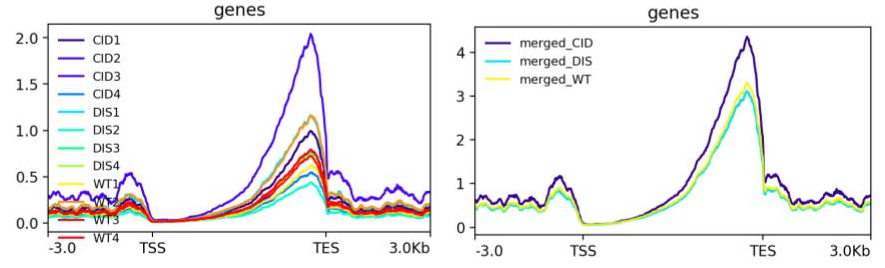

In [154]:
Image('figures_GITHUB/computematrix_demultiplexed.png')

#### Convert bam to sam
> samtools view -h -o out.sam in.bam

In [157]:
!samtools view -h -o BAM/BAM_demultiplexed_first/BED_z_BAM/DIS3.sam BAM/BAM_demultiplexed_first/DIS3Aligned.out.bam

#### Convert bam to bed
> sam2bed < input.sam > output.bed

In [158]:
!sam2bed < BAM/BAM_demultiplexed_first/BED_z_BAM/DIS3.sam >  BAM/BAM_demultiplexed_first/BED_z_BAM/DIS3.bed

#### Convert output bed into bed6
> !bed12ToBed6 -i CID1.bed > CID1_bed6.bed

In [159]:
!bed12ToBed6 -i BAM/BAM_demultiplexed_first/BED_z_BAM/DIS3.bed > BAM/BAM_demultiplexed_first/BED_z_BAM/DIS3_bed6.bed


### Make the counttables

In [217]:
# closest
!bedtools closest -a BAM/BAM_demultiplexed_first/BED_z_BAM/DIS4_bed6.bed -b BAM/BAM_demultiplexed_first/closest/adnotacje_bed6.bed  > BAM/BAM_demultiplexed_first/closest/closets_DIS4.bed

In [204]:
# We will use only forst 12 columns in closest files. We will remove next columns (take only columns 1-12)
#!cut -f 1,2,3,4,5,6,7,8,9,10,11,12,13 BAM/BAM_demultiplexed_first/closest/closets_CID4.bed > BAM/BAM_demultiplexed_first/closest/closets_CID4.bed

In [219]:
column_temporary_names = ['a','b','c','d',
                          'e','f','g','h',
                          'i','j','k','l',
                          'm','n','o','p','r']

In [181]:
samples = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4']

*FOR LOOP HERE to ADD* 

In [274]:
closest_WT4 = pd.read_table('BAM/BAM_demultiplexed_first/closest/closets_WT4.bed', sep = '\t')
closest_WT4.columns = column_temporary_names[0:12]
closest_WT4 = closest_WT4[closest_WT4['a']  != "MT"]
closest_WT4 = closest_WT4[closest_WT4['a']  != "MTR"]
closest_WT4 = closest_WT4[closest_WT4['a']  != "AB325691"]

closest_WT4.head()


,a,b,c,d,e,f,g,h,i,j,k,l
7,I,16910,16970,M01788:48:000000000-CNY9L:1:2110:16320:10871,255,-,I,15854,16226,SPAC212.12,.,+
8,I,20545,109560,M01788:48:000000000-CNY9L:1:1109:20598:21977,255,-,I,20823,21015,SPAC212.05c,.,+
9,I,20545,109560,M01788:48:000000000-CNY9L:1:1109:20598:21977,255,-,I,21380,23050,SPAC212.04c,.,+
10,I,20545,109560,M01788:48:000000000-CNY9L:1:1109:20598:21977,255,-,I,23588,24054,SPAC212.03,.,-
11,I,20545,109560,M01788:48:000000000-CNY9L:1:1109:20598:21977,255,-,I,27352,27763,SPAC212.02,.,-


In [275]:
genes_reads_WT4 = closest_WT4['j'].value_counts()
genes_reads_WT4.to_csv('BAM/BAM_demultiplexed_first/closest/genes_reads_WT4.csv', sep = '\t')

/home/lidia/miniconda2/envs/rnatails/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [291]:
samples = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4']
table_DIS4 = pd.read_csv('BAM/BAM_demultiplexed_first/closest/genes_reads_DIS4.csv', sep = '\t',
                  names=["Genes", "DIS4"])

In [305]:
reads_in_genes_merge = pd.merge(reads_in_genes_merge,table_WT4, on=['Genes'], how='left')

In [306]:
reads_in_genes_merge.to_csv('BAM/BAM_demultiplexed_first/closest/reads_in_genes_merged.csv')

In [315]:
reads_in_genes_merge.head()

,Genes,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4,WT1,WT2,WT3,WT4
0,SPCC1223.02,292,213.0,431.0,167.0,340.0,117.0,192.0,160.0,166.0,324.0,174.0,202.0
1,SPBC32F12.11,278,168.0,449.0,149.0,312.0,328.0,211.0,238.0,207.0,308.0,220.0,273.0
2,SPBC1815.01,268,225.0,526.0,184.0,320.0,144.0,265.0,225.0,183.0,324.0,244.0,225.0
3,SPBC19C2.07,196,136.0,353.0,116.0,202.0,81.0,142.0,142.0,121.0,189.0,113.0,145.0
4,SPCC13B11.01,195,152.0,357.0,119.0,225.0,81.0,146.0,158.0,122.0,180.0,127.0,156.0


In [317]:
 df = reads_in_genes_merge[['Genes','WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4']]
df.head()

,Genes,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
0,SPCC1223.02,166.0,324.0,174.0,202.0,292,213.0,431.0,167.0,340.0,117.0,192.0,160.0
1,SPBC32F12.11,207.0,308.0,220.0,273.0,278,168.0,449.0,149.0,312.0,328.0,211.0,238.0
2,SPBC1815.01,183.0,324.0,244.0,225.0,268,225.0,526.0,184.0,320.0,144.0,265.0,225.0
3,SPBC19C2.07,121.0,189.0,113.0,145.0,196,136.0,353.0,116.0,202.0,81.0,142.0,142.0
4,SPCC13B11.01,122.0,180.0,127.0,156.0,195,152.0,357.0,119.0,225.0,81.0,146.0,158.0


In [318]:
df = df.dropna()
df = df.set_index("Genes")
df.shape

(4482, 12)

In [335]:
df.head()

,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
Genes,,,,,,,,,,,,
SPCC1223.02,166.0,324.0,174.0,202.0,292,213.0,431.0,167.0,340.0,117.0,192.0,160.0
SPBC32F12.11,207.0,308.0,220.0,273.0,278,168.0,449.0,149.0,312.0,328.0,211.0,238.0
SPBC1815.01,183.0,324.0,244.0,225.0,268,225.0,526.0,184.0,320.0,144.0,265.0,225.0
SPBC19C2.07,121.0,189.0,113.0,145.0,196,136.0,353.0,116.0,202.0,81.0,142.0,142.0
SPCC13B11.01,122.0,180.0,127.0,156.0,195,152.0,357.0,119.0,225.0,81.0,146.0,158.0


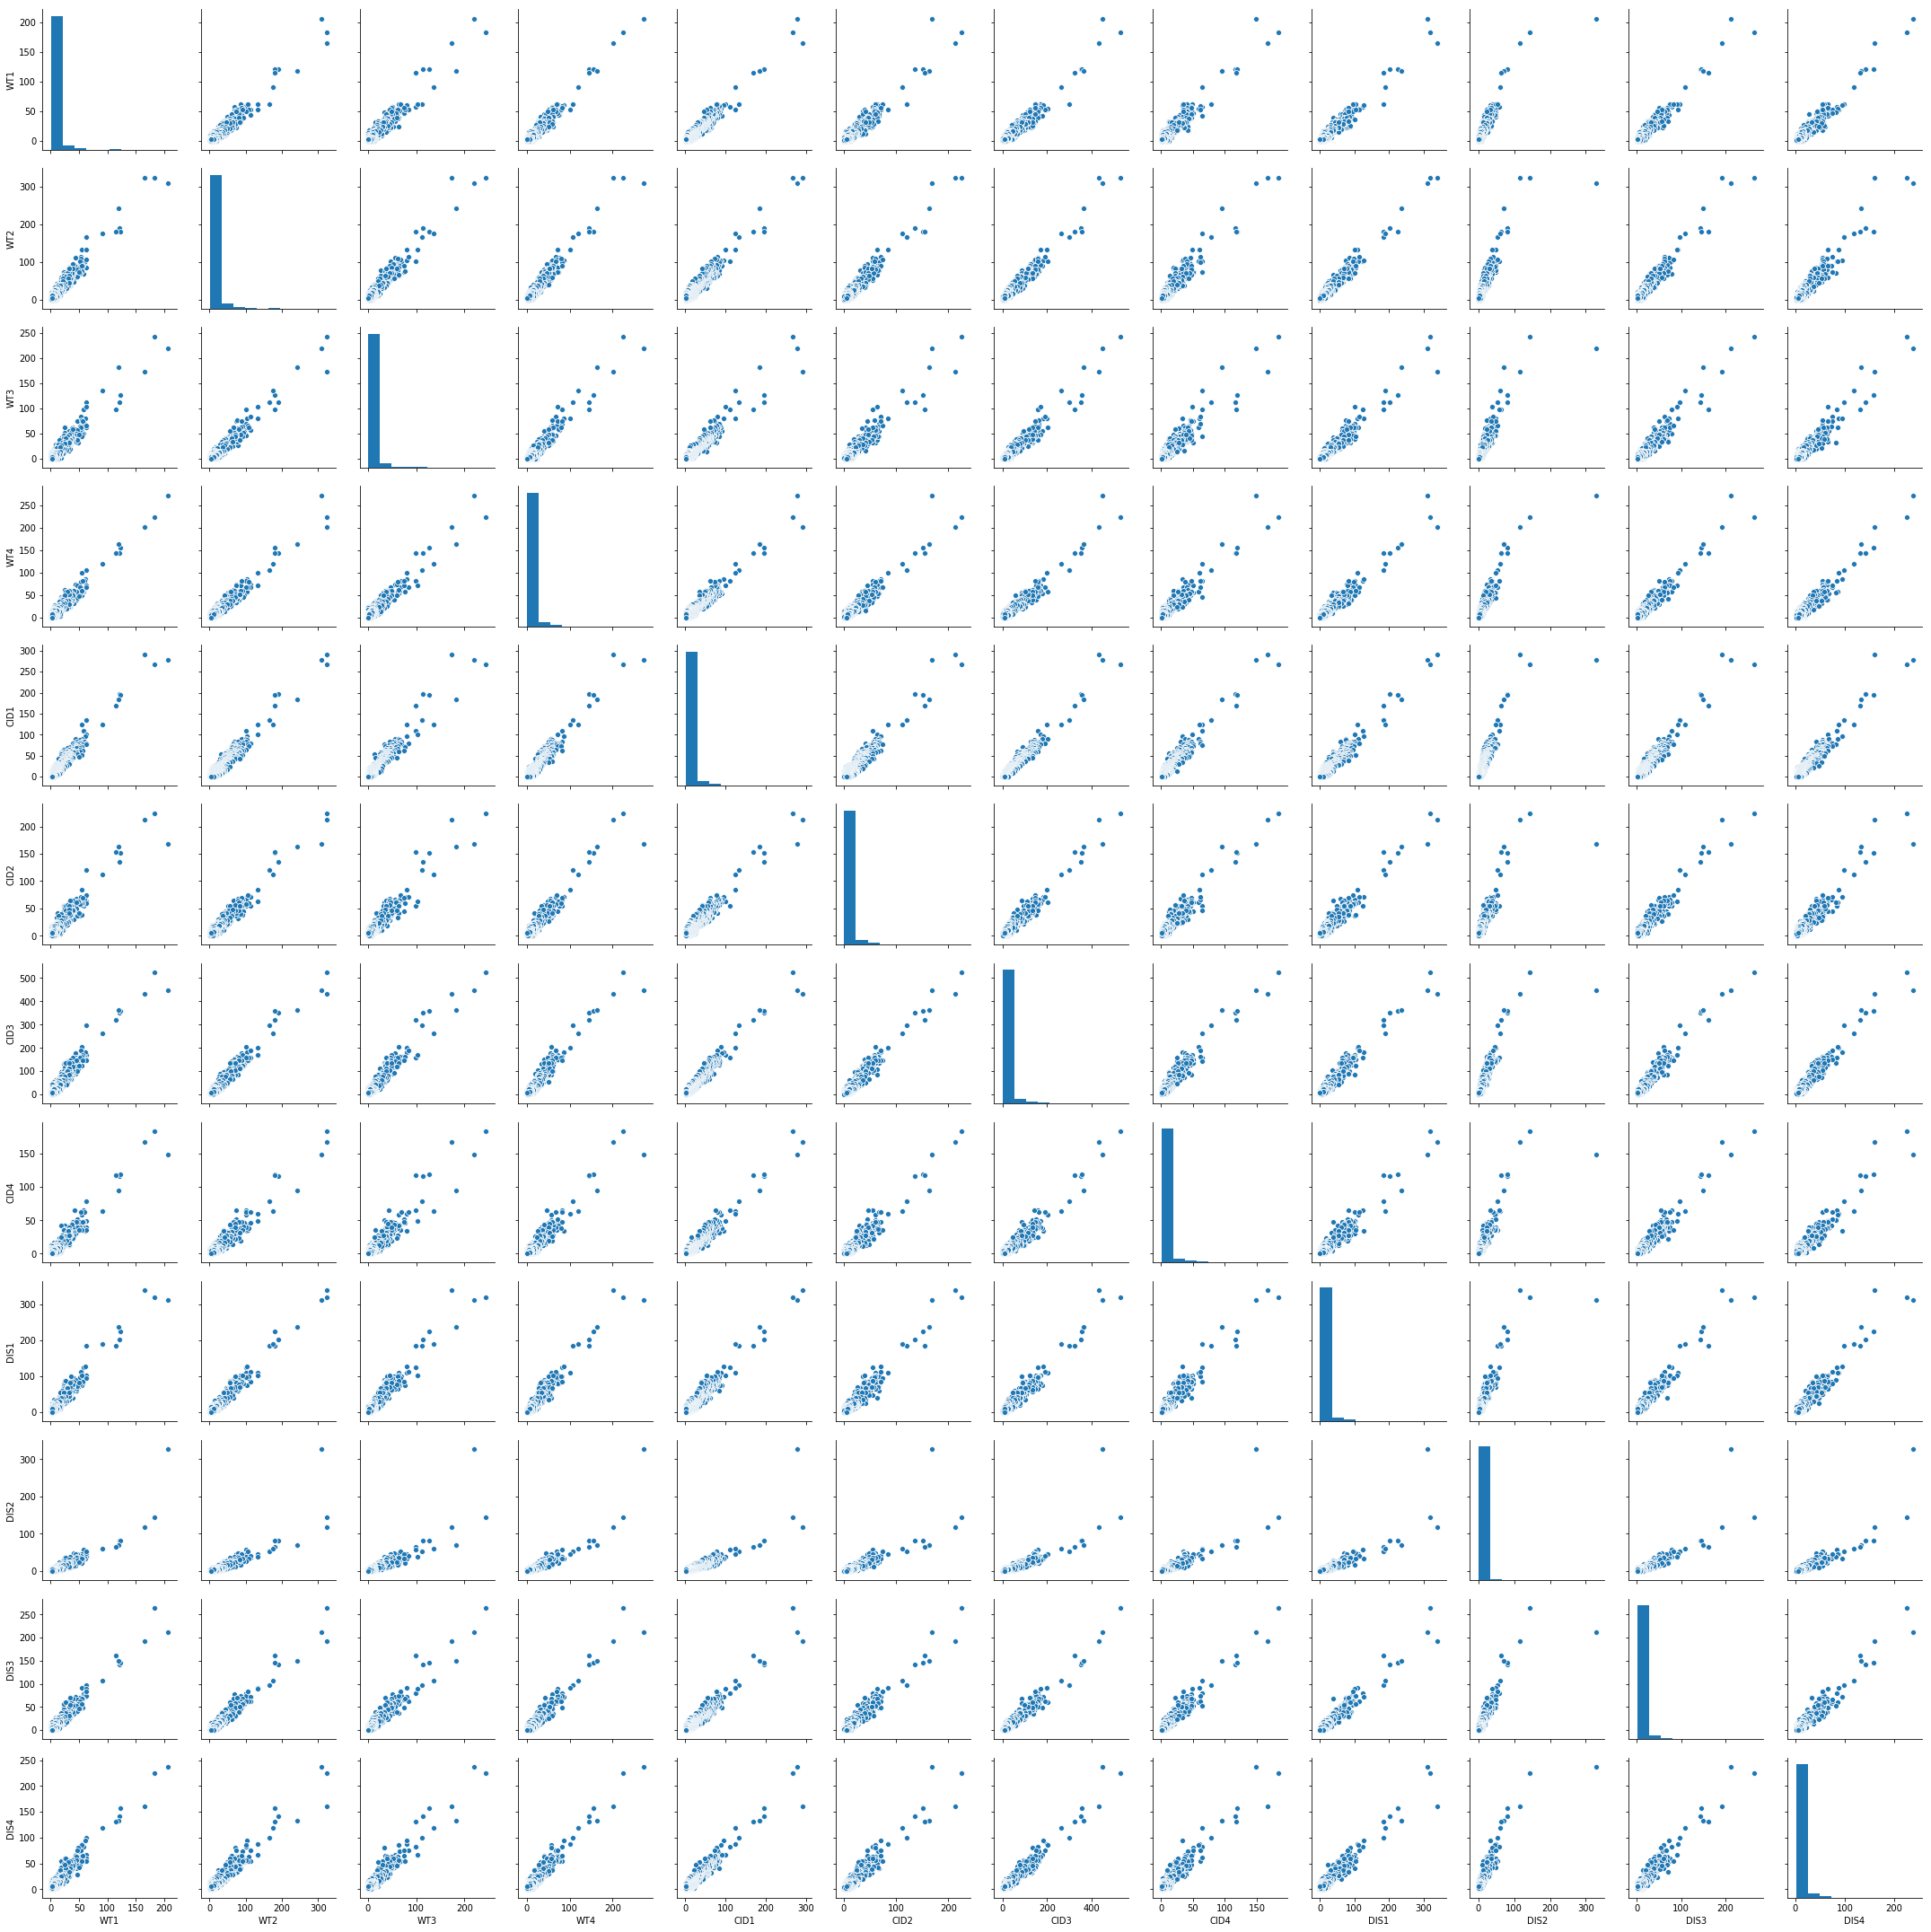

In [319]:
# Vizualization before normalisation
sns.pairplot(df)

### Filtration of data - only genes with at least 6 reads in at least one sample


In [328]:
new_df = df[df.loc[:]>5].dropna()
new_df.shape

(511, 12)

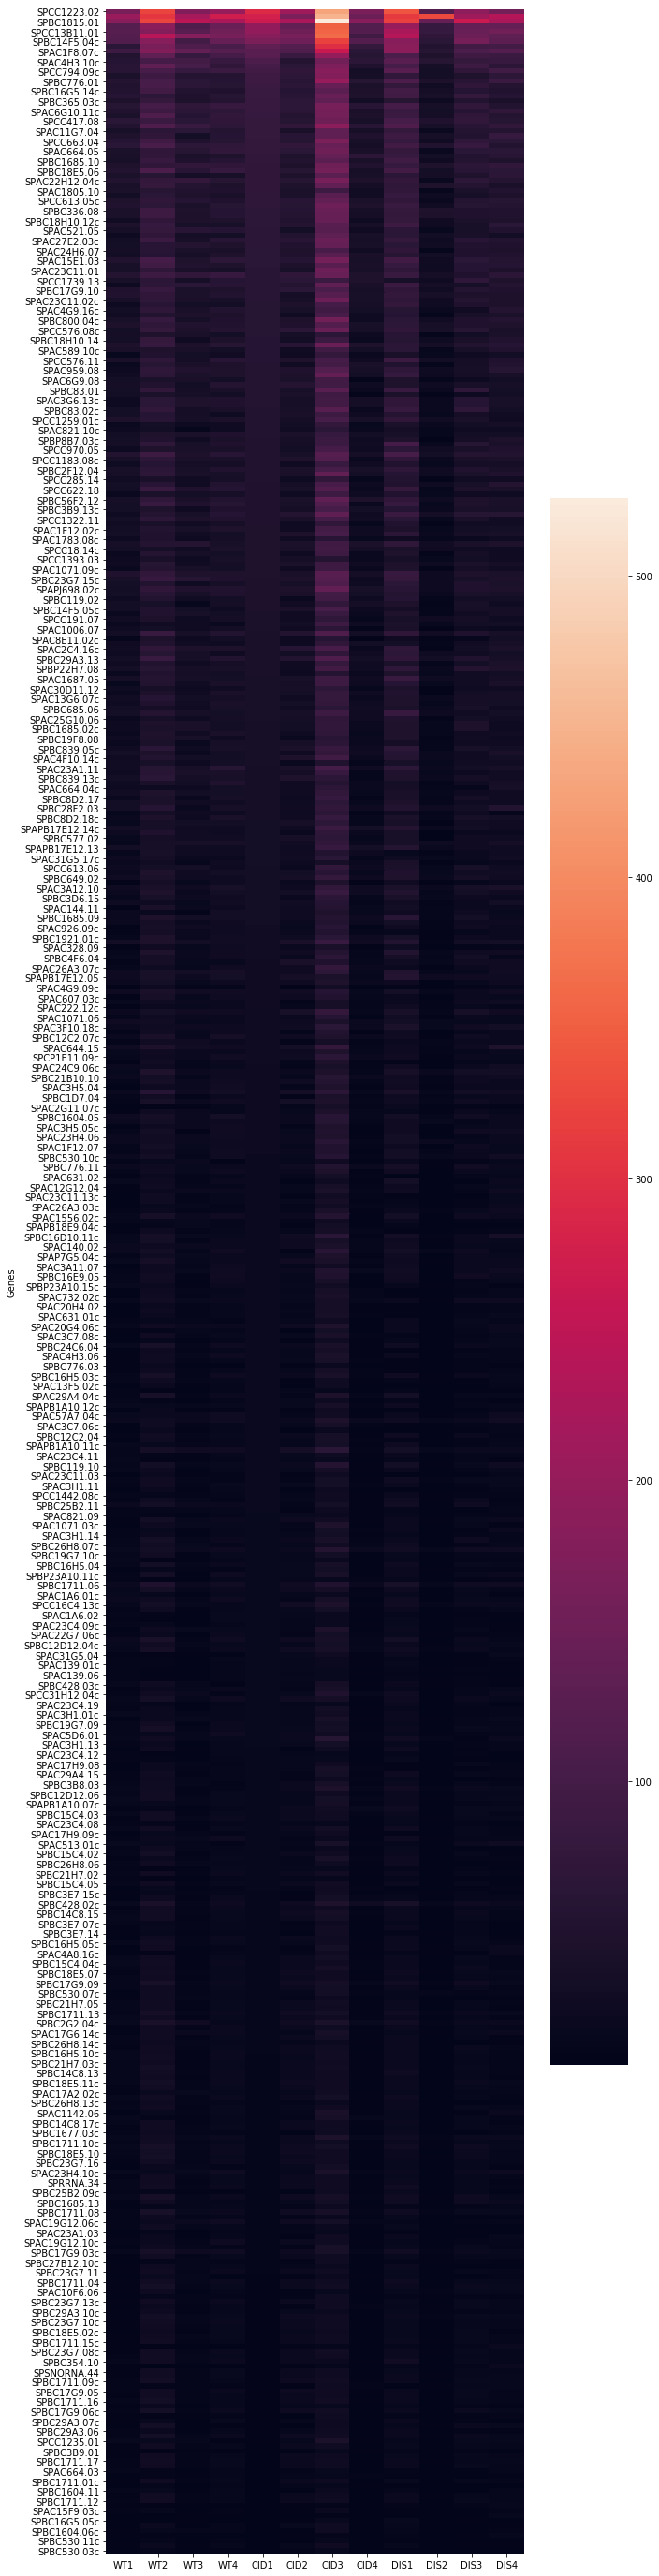

In [329]:
plt.subplots(figsize=(10,50))
sns.heatmap(new_df)

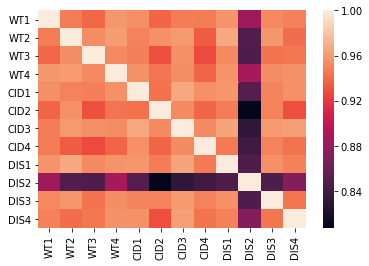

In [330]:
corr = new_df.corr()
sns.heatmap(corr)

In [327]:
new_df.head()

,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
Genes,,,,,,,,,,,,
SPCC1223.02,7.711455,7.865273,7.066762,6.828658,9.048636,7.635962,6.778106,8.898540,8.761914,7.763537,7.050302,5.987550
SPBC32F12.11,9.616091,7.476865,8.934986,9.228830,8.614797,6.022730,7.061182,7.939416,8.040345,21.764446,7.747988,8.906481
SPBC1815.01,8.501182,7.865273,9.909712,7.606179,8.304912,8.066157,8.272120,9.804380,8.246508,9.555123,9.730885,8.419993
SPBC19C2.07,5.621000,4.588076,4.589334,4.901760,6.073742,4.875544,5.551442,6.181022,5.205608,5.374757,5.214286,5.313951
SPCC13B11.01,5.667455,4.369596,5.157924,5.273617,6.042753,5.449137,5.614348,6.340876,5.798326,5.374757,5.361167,5.912706


In [325]:
#Normalization - the results for each sample are divided by the mean value from the column
df_pca = new_df

columns = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4']

for i in columns:
    mean_i = df_pca[i].mean()
    df_pca[i] = df_pca[i]/mean_i
df_pca.head()

,WT1,WT2,WT3,WT4,CID1,CID2,CID3,CID4,DIS1,DIS2,DIS3,DIS4
Genes,,,,,,,,,,,,
SPCC1223.02,7.711455,7.865273,7.066762,6.828658,9.048636,7.635962,6.778106,8.898540,8.761914,7.763537,7.050302,5.987550
SPBC32F12.11,9.616091,7.476865,8.934986,9.228830,8.614797,6.022730,7.061182,7.939416,8.040345,21.764446,7.747988,8.906481
SPBC1815.01,8.501182,7.865273,9.909712,7.606179,8.304912,8.066157,8.272120,9.804380,8.246508,9.555123,9.730885,8.419993
SPBC19C2.07,5.621000,4.588076,4.589334,4.901760,6.073742,4.875544,5.551442,6.181022,5.205608,5.374757,5.214286,5.313951
SPCC13B11.01,5.667455,4.369596,5.157924,5.273617,6.042753,5.449137,5.614348,6.340876,5.798326,5.374757,5.361167,5.912706


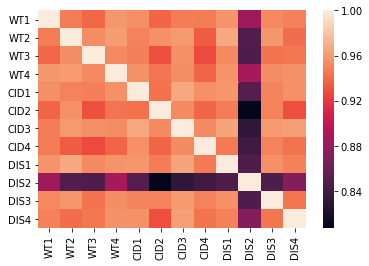

In [326]:
corr_normaized = df_pca.corr()
sns.heatmap(corr_normaized)

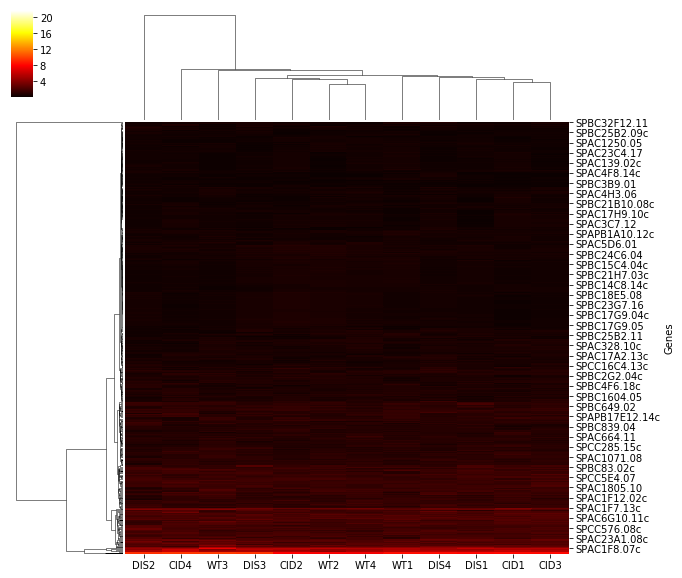

In [331]:
sns.clustermap(df_pca, cmap ='hot')

In [332]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=5)
pca.fit(df_pca)
pca.components_ 

array([[ 0.28523584,  0.25782697,  0.30262029,  0.2628859 ,  0.29966583,
         0.25151779,  0.28071795,  0.30129768,  0.29330385,  0.35811231,
         0.28080348,  0.27515796],
       [ 0.01457336, -0.11311891, -0.11038976,  0.00990585, -0.12356479,
        -0.21126418, -0.19350245, -0.14060488, -0.13918825,  0.90661334,
        -0.12576864, -0.02133307],
       [-0.16305988,  0.29312009,  0.57905636,  0.17539441, -0.17552971,
        -0.01429418,  0.01000588, -0.6829299 ,  0.13651483, -0.01185366,
        -0.06320038, -0.03381075],
       [ 0.18061857,  0.32284856, -0.39350231,  0.08477932, -0.32432791,
         0.4741323 , -0.18140568, -0.12606081,  0.14180824,  0.05251847,
         0.32159947, -0.44275363],
       [-0.25388665,  0.02207686,  0.52750335, -0.17652766, -0.27080868,
        -0.08248912, -0.13600229,  0.50564709, -0.15195342,  0.07014576,
         0.26661038, -0.41499835]])

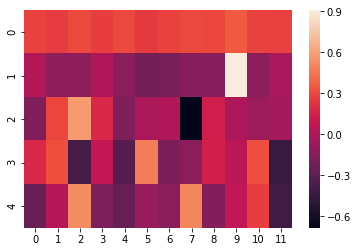

In [334]:
sns.heatmap(pca.components_)

In [351]:
########################### Tu w tej komorce coś do poprawki

columns = ['WT1', 'WT2', 'WT3', 'WT4',
           'CID1', 'CID2', 'CID3', 'CID4',
           'DIS1', 'DIS2', 'DIS3', 'DIS4']

samples = pd.Series(columns)
rows = list(df.index)

tablename_DIS4 = pd.DataFrame({
    'genes': rows,
    'reads': df['DIS4']})

In [366]:
tablename_DIS4['sample'] = 'DIS4'

In [367]:
frames = [tablename_WT1, tablename_WT2, tablename_WT3, tablename_WT4, tablename_CID1, tablename_CID2, tablename_CID3, tablename_CID4,
         tablename_DIS1, tablename_DIS2, tablename_DIS3, tablename_DIS4]

concatenated_tables = pd.concat(frames)
concatenated_tables.to_csv('BAM/BAM_demultiplexed_first/concatenated_tables_2.csv')

In [386]:
concatenated_tables2 = pd.read_csv('BAM/BAM_demultiplexed_first/concatenated_tables_1.csv')

In [388]:
concatenated_tables2 = concatenated_tables2.drop(columns=['genes'])
concatenated_tables2 = concatenated_tables2.set_index("Genes")
concatenated_tables2.head()

,reads,sample,sample_mean
Genes,,,
SPCC1223.02,166,WT1,WT
SPBC32F12.11,207,WT1,WT
SPBC1815.01,183,WT1,WT
SPBC19C2.07,121,WT1,WT
SPCC13B11.01,122,WT1,WT


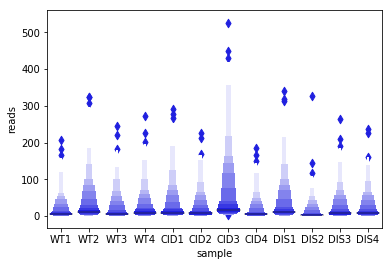

In [394]:
sns.boxenplot(x="sample", y="reads", color="b",
              scale="linear", data=concatenated_tables2)

In [ ]:
# TO DO FOR ME: clean the code